In [2]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import yfinance as yf
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# Import live assets to calculate daily returs and correlation matrix
assets = ["AAPL", "MSFT", "NVDA", "JPM", "MA", "XOM", "JNJ", "PG", "KO", "CAT", "META", "DUK"]

data = yf.download(assets, start="2018-01-01", end="2025-10-31", auto_adjust=True)["Close"]

returns = data.pct_change().dropna()

corr_matrix = returns.corr()

[*********************100%***********************]  12 of 12 completed


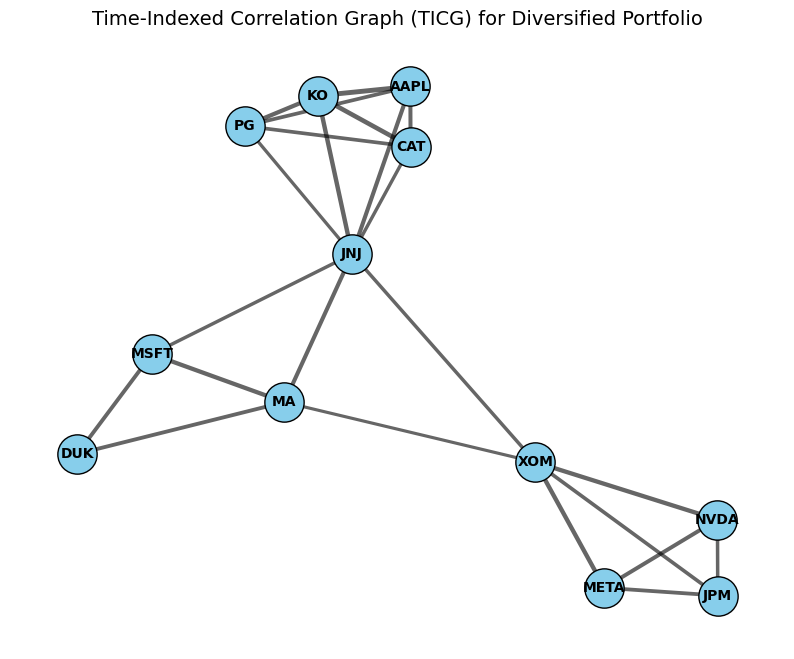


Correlation Matrix:
Ticker   AAPL    CAT    DUK    JNJ    JPM     KO     MA   META   MSFT   NVDA  \
Ticker                                                                         
AAPL    1.000  0.403  0.269  0.321  0.434  0.356  0.595  0.535  0.705  0.576   
CAT     0.403  1.000  0.242  0.305  0.616  0.333  0.497  0.286  0.407  0.387   
DUK     0.269  0.242  1.000  0.505  0.370  0.623  0.368  0.117  0.270  0.086   
JNJ     0.321  0.305  0.505  1.000  0.364  0.528  0.389  0.158  0.328  0.121   
JPM     0.434  0.616  0.370  0.364  1.000  0.451  0.590  0.331  0.449  0.362   
KO      0.356  0.333  0.623  0.528  0.451  1.000  0.501  0.176  0.363  0.157   
MA      0.595  0.497  0.368  0.389  0.590  0.501  1.000  0.474  0.636  0.490   
META    0.535  0.286  0.117  0.158  0.331  0.176  0.474  1.000  0.611  0.528   
MSFT    0.705  0.407  0.270  0.328  0.449  0.363  0.636  0.611  1.000  0.663   
NVDA    0.576  0.387  0.086  0.121  0.362  0.157  0.490  0.528  0.663  1.000   
PG      0.365  0.23

In [ ]:
# Using the correlation matrix to produce a graph, all assets will be the nodes and correlation above the threshold (weight) will be the edges

G = nx.Graph()
for i in range(len(assets)):
    for j in range(i + 1, len(assets)):
        weight = abs(corr_matrix.iloc[i, j])   
        if weight > 0.45:  # threshold to remove weak correlations (tunable)
            G.add_edge(assets[i], assets[j], weight=weight)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, weight='weight')

edges = G.edges(data=True)
weights = [d['weight'] * 5 for (_, _, d) in edges] 

nx.draw_networkx_nodes(G, pos, node_size=800, node_color="skyblue", edgecolors='k')
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Time-Indexed Correlation Graph (TICG) for Diversified Portfolio", fontsize=14)
plt.axis("off")
plt.show()

print("\nCorrelation Matrix:")
print(corr_matrix.round(3))

QUBO matrix (Q):

      AAPL  JNJ   PG   KO  CAT  MSFT   MA  DUK  NVDA  JPM  XOM  META
AAPL  -1.0  0.0  0.0  0.0  0.0   2.0  2.0  2.0   2.0  2.0  2.0   2.0
JNJ    0.0 -1.0  0.0  0.0  0.0   0.0  0.0  2.0   2.0  2.0  0.0   2.0
PG     0.0  0.0 -1.0  0.0  0.0   2.0  2.0  2.0   2.0  2.0  2.0   2.0
KO     0.0  0.0  0.0 -1.0  0.0   2.0  2.0  2.0   2.0  2.0  2.0   2.0
CAT    0.0  0.0  0.0  0.0 -1.0   2.0  2.0  2.0   2.0  2.0  2.0   2.0
MSFT   2.0  0.0  2.0  2.0  2.0  -1.0  0.0  0.0   2.0  2.0  2.0   2.0
MA     2.0  0.0  2.0  2.0  2.0   0.0 -1.0  0.0   2.0  2.0  0.0   2.0
DUK    2.0  2.0  2.0  2.0  2.0   0.0  0.0 -1.0   2.0  2.0  2.0   2.0
NVDA   2.0  2.0  2.0  2.0  2.0   2.0  2.0  2.0  -1.0  0.0  0.0   0.0
JPM    2.0  2.0  2.0  2.0  2.0   2.0  2.0  2.0   0.0 -1.0  0.0   0.0
XOM    2.0  0.0  2.0  2.0  2.0   2.0  0.0  2.0   0.0  0.0 -1.0   0.0
META   2.0  2.0  2.0  2.0  2.0   2.0  2.0  2.0   0.0  0.0  0.0  -1.0


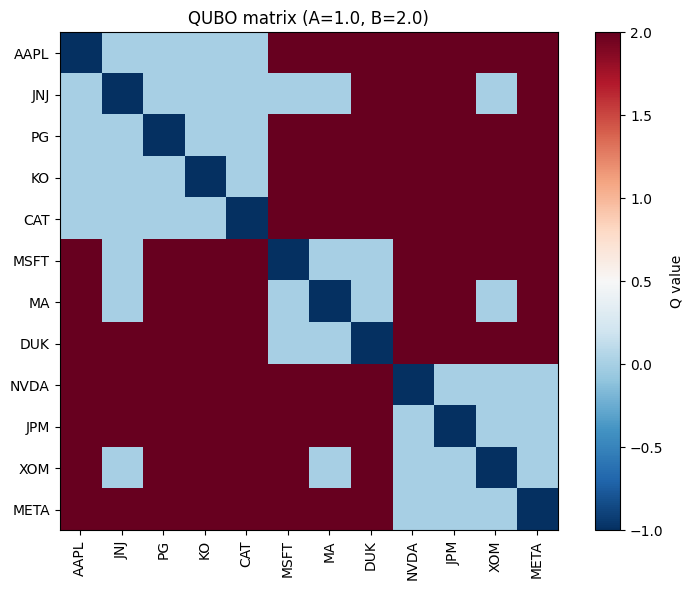

In [ ]:
#Formation of QUBO matrix using A and B as parametersof the quadratic equation.

A = 1.0      # reward coefficient (linear)
B = 2.0      # penalty coefficient for non-edges (quadratic)

nodes = list(G.nodes())
n = len(nodes)

G_comp = nx.complement(G)

Q = np.zeros((n, n), dtype=float)

for i in range(n):
    Q[i, i] = -A

for i in range(n):
    for j in range(i+1, n):
        if G_comp.has_edge(nodes[i], nodes[j]):
            Q[i, j] = Q[j, i] = B

Q_df = pd.DataFrame(Q, index=nodes, columns=nodes)
print("QUBO matrix (Q):\n")
print(Q_df.round(3))

# Better visualtization of correlation using heatmap

plt.figure(figsize=(8,6))
plt.imshow(Q, interpolation='nearest', cmap='RdBu_r')
plt.colorbar(label='Q value')
plt.xticks(range(n), nodes, rotation=90)
plt.yticks(range(n), nodes)
plt.title(f"QUBO matrix (A={A}, B={B})")
plt.tight_layout()
plt.show()

In [ ]:
# Extracting Ising coefficient from QUBO and then applying QAOA for solving it's ground state.

n = len(assets)

Q = np.random.uniform(-1, 1, size=(n, n))
Q = 0.5 * (Q + Q.T)  # make symmetric

# Extract Ising coefficients
h = np.zeros(n)
J = np.zeros((n, n))
for i in range(n):
    h[i] = Q[i, i]
    for j in range(i + 1, n):
        J[i, j] = Q[i, j] / 2

dev_analytic = qml.device("default.qubit", wires=n)

p = 5  # QAOA depth -> Increasing it should improve final solution

def cost_layer(gamma):
    """Applies cost Hamiltonian exp(-i gamma H_C)"""
    for i in range(n):
        qml.RZ(2 * h[i] * gamma, wires=i)
    for i in range(n):
        for j in range(i + 1, n):
            if J[i, j] != 0:
                qml.CNOT(wires=[i, j])
                qml.RZ(2 * J[i, j] * gamma, wires=j)
                qml.CNOT(wires=[i, j])

def mixer_layer(beta):
    """Applies mixing Hamiltonian exp(-i beta H_M)"""
    for i in range(n):
        qml.RX(2 * beta, wires=i)

# Defining QAOA circuit

@qml.qnode(dev_analytic)
def qaoa_expectation(params):
    gammas = params[:p]
    betas = params[p:]

    for i in range(n):
        qml.Hadamard(wires=i)
    for layer in range(p):
        cost_layer(gammas[layer])
        mixer_layer(betas[layer])

    coeffs = []
    obs = []
    for i in range(n):
        if h[i] != 0:
            coeffs.append(h[i])
            obs.append(qml.Z(i))
    for i in range(n):
        for j in range(i + 1, n):
            if J[i, j] != 0:
                coeffs.append(J[i, j])
                obs.append(qml.Z(i) @ qml.Z(j))
    H = qml.Hamiltonian(coeffs, obs)
    return qml.expval(H)

# Using AdamOptimizer for classical parameter optimization

opt = qml.AdamOptimizer(stepsize=0.001)
maxiter = 300 # Stepsize and number of iterations 
init_params = np.random.uniform(0, np.pi, 2 * p, requires_grad=True)
params = init_params

print("Starting QAOA optimization...")
for it in range(maxiter):
    params, prev_cost = opt.step_and_cost(qaoa_expectation, params)
    if it % 10 == 0 or it == maxiter - 1:
        print(f"Iter {it:03d} | Energy = {prev_cost:.6f}")

print("\nOptimization finished.")
print("Optimal parameters:", params)


dev_sample = qml.device("default.qubit", wires=n, shots=2000)

@qml.qnode(dev_sample)
def sample_qaoa(params):
    gammas = params[:p]
    betas = params[p:]
    for i in range(n):
        qml.Hadamard(wires=i)
    for layer in range(p):
        cost_layer(gammas[layer])
        mixer_layer(betas[layer])
    return qml.sample(wires=range(n))

samples = sample_qaoa(params)
samples = np.array(samples)

bitstrings = ["".join(str(int(b)) for b in s) for s in samples]
(unique, counts) = np.unique(bitstrings, return_counts=True)
sorted_results = sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)

print("\nMost probable bitstrings and selected assets:")
for bs, count in sorted_results[:5]:
    selected = [assets[i] for i, bit in enumerate(bs) if bit == "1"]
    print(f"{bs} -> {count} samples ({100*count/len(samples):.2f}%) | Selected: {selected if selected else 'None'}")


Starting QAOA optimization...
Iter 000 | Energy = 0.507448
Iter 010 | Energy = 0.453753
Iter 020 | Energy = 0.403982
Iter 030 | Energy = 0.358034
Iter 040 | Energy = 0.315846
Iter 050 | Energy = 0.277042
Iter 060 | Energy = 0.240861
Iter 070 | Energy = 0.206514
Iter 080 | Energy = 0.173732
Iter 090 | Energy = 0.142769
Iter 100 | Energy = 0.114097
Iter 110 | Energy = 0.088146
Iter 120 | Energy = 0.065125
Iter 130 | Energy = 0.044963
Iter 140 | Energy = 0.027398
Iter 150 | Energy = 0.012140
Iter 160 | Energy = -0.001036
Iter 170 | Energy = -0.012307
Iter 180 | Energy = -0.021870
Iter 190 | Energy = -0.029975
Iter 200 | Energy = -0.036924
Iter 210 | Energy = -0.043047
Iter 220 | Energy = -0.048661
Iter 230 | Energy = -0.054031
Iter 240 | Energy = -0.059325
Iter 250 | Energy = -0.064598
Iter 260 | Energy = -0.069812
Iter 270 | Energy = -0.074874
Iter 280 | Energy = -0.079681
Iter 290 | Energy = -0.084148
Iter 299 | Energy = -0.087835

Optimization finished.
Optimal parameters: [ 1.32400753

In [6]:
# Improved QAOA pipeline with many practical accuracy improvements
# - normalization, warm-start, layerwise training, restarts, lr decay
# - hill-climb postprocessing, CVaR selection, brute-force verification for small n
# - uses PennyLane statevector for optimization + shot-based sampling for final readout

import time
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import networkx as nx
from collections import Counter
import itertools
import math
import random
import copy

# ---------------------- USER-TUNABLES ----------------------
# Core algorithmic hyperparams
max_p = 5                 # target QAOA depth (will be trained layerwise 1..max_p)
rest_starts = 6           # number of random restarts (one of them will be warm-start when available)
inner_steps = 200         # optimizer steps per layer per restart
initial_lr = 0.05         # initial Adam stepsize
lr_decay = 0.98           # multiplicative decay per 50 iterations (tunable)
use_spsa_fallback = False # if True, use SPSA for noisy optimization
spsa_steps = 300
shots = 5000              # sampling shots for final extraction (increase for stability)
cvar_alpha = 0.10         # CVaR fraction: look at lowest alpha-percent energies among samples (0-1)
hill_climb_enabled = True
bruteforce_check = True   # only if n <= 20

# Warm-start / heuristic options
enable_warmstart = True   # attempt to produce a classical candidate (greedy clique) to seed parameters
warmstart_perturb = 0.15  # fraction of random noise added to warmstart params to avoid saddle points

# Misc
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

# ---------------------- Build/validate Q and assets ----------------------
# Assumes user may already have Q (numpy array) and assets (list) defined in environment.
try:
    Q  # if present, use it
    Q = np.array(Q, dtype=float)
    assets = list(assets)
except NameError:
    # fallback: try to build Q from graph G using A=1, B=2 as earlier
    try:
        nodes = list(G.nodes())
        assets = nodes.copy()
        n = len(nodes)
        A = 1.0
        B = 2.0
        Q = np.zeros((n, n), dtype=float)
        for i in range(n):
            Q[i, i] = -A
        G_comp = nx.complement(G)
        for i in range(n):
            for j in range(i+1, n):
                if G_comp.has_edge(nodes[i], nodes[j]):
                    Q[i, j] = Q[j, i] = B
        print("Built Q from complement graph (A=1, B=2)")
    except NameError:
        raise RuntimeError("Please define either Q (numpy array) and assets (list) or G (networkx graph).")

# enforce shapes
n = Q.shape[0]
assert len(assets) == n, "assets list length must equal Q shape"

# ---------------------- Utility functions ----------------------
def qubo_energy_bitvec(bitvec, Qmat):
    x = np.array(bitvec, dtype=int)
    return float(x @ Qmat @ x)

def local_hill_climb(x_vec, Qmat):
    """Bit-flip hill climb: greedily flip bits to reduce energy until no improvement."""
    x = x_vec.copy().astype(int)
    best_e = qubo_energy_bitvec(x, Qmat)
    improved = True
    while improved:
        improved = False
        for i in range(len(x)):
            x_try = x.copy()
            x_try[i] = 1 - x_try[i]
            e = qubo_energy_bitvec(x_try, Qmat)
            if e < best_e - 1e-12:
                x = x_try
                best_e = e
                improved = True
                break
    return x, best_e

def greedy_clique_from_graph(G):
    """
    Simple heuristic to produce a good clique:
    - start with highest-degree node, greedily add nodes that are connected to all current clique members
    - try starting from several seeds (top degree nodes)
    Returns best bitvector found.
    """
    nodes = list(G.nodes())
    deg_sorted = sorted(nodes, key=lambda u: G.degree(u), reverse=True)
    best_clique = []
    for seed in deg_sorted[:min(len(nodes), 8)]:  # try up to top-8 seeds
        clique = [seed]
        for candidate in deg_sorted:
            if candidate in clique:
                continue
            if all(G.has_edge(candidate, c) for c in clique):
                clique.append(candidate)
        if len(clique) > len(best_clique):
            best_clique = clique
    bit = np.zeros(len(nodes), dtype=int)
    for i, node in enumerate(nodes):
        if node in best_clique:
            bit[i] = 1
    return bit

def bitvec_to_str(x):
    return "".join(str(int(b)) for b in x)

# ---------------------- Normalize QUBO ----------------------
max_abs = np.max(np.abs(Q))
scale = float(max_abs) if max_abs != 0 else 1.0
Qn = Q / scale
print(f"Normalized Q by scale = {scale:.6g} (use Qn for circuit; scale back energies later)")

# ---------------------- Map QUBO -> Ising coefficients ----------------------
# QUBO: E(x) = x^T Qn x = sum_i q_i x_i + sum_{i<j} q_ij x_i x_j
q_i = np.array([Qn[i, i] for i in range(n)])
q_ij = {}
for i in range(n):
    for j in range(i+1, n):
        if abs(Qn[i, j]) > 1e-15:
            q_ij[(i, j)] = float(Qn[i, j])

# map x = (1 - Z)/2  => E(x) = const_n + sum_i h_i Z_i + sum_{i<j} J_ij Z_i Z_j
const_n = 0.0
for i in range(n):
    const_n += q_i[i] / 2.0
for (i, j), val in q_ij.items():
    const_n += val / 4.0

h = np.zeros(n)
for i in range(n):
    s = 0.0
    for j in range(n):
        if i == j:
            continue
        a, b = (i, j) if i < j else (j, i)
        if (a, b) in q_ij:
            s += q_ij[(a, b)]
    h[i] = - q_i[i] / 2.0 - 0.25 * s

J = {}
for (i, j), val in q_ij.items():
    J[(i, j)] = val / 4.0

print("Ising mapping complete. Example h[:min(5,n)]:", np.round(h[:min(5,n)], 6), "const_n:", round(const_n, 6))

# ---------------------- Warm-start heuristic (greedy) ----------------------
warm_bit = None
if enable_warmstart:
    # try to infer original G if available; else fallback to greedy using Q structure
    try:
        # If G exists we used earlier, use it. Otherwise attempt constructing similarity graph from Q.
        if 'G' in globals():
            warm_bit = greedy_clique_from_graph(G)
        else:
            # heuristic: create graph by thresholding correlation-like Q diagonal/off-diagonal
            thresh = np.median(Qn[np.triu_indices(n, 1)])
            G_temp = nx.Graph()
            G_temp.add_nodes_from(range(n))
            for (i, j), val in q_ij.items():
                if val < thresh:  # this heuristic may not be perfect; use fallback
                    G_temp.add_edge(i, j)
            warm_bit = greedy_clique_from_graph(G_temp)
    except Exception:
        warm_bit = None

if warm_bit is not None and warm_bit.sum() > 0:
    print("Warm-start heuristic found candidate with size", warm_bit.sum())
else:
    warm_bit = None
    print("No warm-start candidate found or empty.")

# ---------------------- QAOA primitives ----------------------
# analytic device for optimization (statevector, adjoint diff for efficiency)
dev_analytic = qml.device("default.qubit", wires=n)
diff_method = "adjoint"  # fast analytic gradients
# sample device used for final sampling (shots)
dev_sample = qml.device("default.qubit", wires=n, shots=shots)

def make_cost_layer(h, J):
    def cost_layer(gamma):
        # single-Z rotations
        for i in range(n):
            if abs(h[i]) > 0:
                qml.RZ(2.0 * float(h[i]) * gamma, wires=i)
        # ZZ couplings implemented via CNOT-RZ-CNOT
        for (i, j), Jij in J.items():
            if abs(Jij) > 0:
                qml.CNOT(wires=[i, j])
                qml.RZ(2.0 * float(Jij) * gamma, wires=j)
                qml.CNOT(wires=[i, j])
    return cost_layer

def make_mixer_layer():
    def mixer_layer(beta):
        for i in range(n):
            qml.RX(2.0 * beta, wires=i)
    return mixer_layer

# ---------------------- QNode factories ----------------------
def qaoa_expectation_factory(p_depth):
    cost_layer = make_cost_layer(h, J)
    mixer_layer = make_mixer_layer()
    @qml.qnode(dev_analytic, diff_method=diff_method)
    def qaoa_expectation(params):
        gammas = params[:p_depth]
        betas = params[p_depth:]
        # initial uniform superposition
        for i in range(n):
            qml.Hadamard(wires=i)
        for layer in range(p_depth):
            cost_layer(gammas[layer])
            mixer_layer(betas[layer])
        # build Hamiltonian (no constant)
        coeffs = []
        obs = []
        for i in range(n):
            if abs(h[i]) > 0:
                coeffs.append(float(h[i]))
                obs.append(qml.PauliZ(i))
        for (i, j), Jij in J.items():
            if abs(Jij) > 0:
                coeffs.append(float(Jij))
                obs.append(qml.PauliZ(i) @ qml.PauliZ(j))
        H = qml.Hamiltonian(coeffs, obs)
        return qml.expval(H)
    return qaoa_expectation

def sample_qaoa_factory(p_depth):
    cost_layer = make_cost_layer(h, J)
    mixer_layer = make_mixer_layer()
    @qml.qnode(dev_sample)
    def sample_qaoa(params):
        gammas = params[:p_depth]
        betas = params[p_depth:]
        for i in range(n):
            qml.Hadamard(wires=i)
        for layer in range(p_depth):
            cost_layer(gammas[layer])
            mixer_layer(betas[layer])
        return qml.sample(wires=range(n))
    return sample_qaoa

# ---------------------- Parameter initialization helpers ----------------------
def random_params(p_depth, scale=1.0):
    # initialize gammas and betas in [0, pi] scaled by scale
    return pnp.array(np.random.uniform(0, np.pi*scale, size=2*p_depth), requires_grad=True)

def warmstart_params_from_bit(bitvec, p_depth):
    """
    Heuristic to produce parameters biased toward a classical warm-start bitvector.
    Not a rigorous method; we create small gammas that encourage the warm bitstring phases,
    and betas near pi/4 (mixing).
    """
    k = int(max(1, bitvec.sum()))
    # gammas scaled by clique size and small positive value
    gammas = np.clip(0.5 * (k / max(1, n)) * np.ones(p_depth), 1e-3, 0.8)
    betas = 0.5 * np.ones(p_depth)  # moderate mixer
    params = np.concatenate([gammas, betas])
    # add small randomness to escape saddles
    params = params + np.random.normal(scale=warmstart_perturb, size=params.shape)
    return pnp.array(params, requires_grad=True)

# ---------------------- Optimization helpers ----------------------
def optimize_with_adam(qnode, p_depth, init_params, steps, lr, lr_decay=0.95):
    """Optimize QAOA parameters using Adam with gradual LR decay."""
    params = init_params
    opt = qml.AdamOptimizer(stepsize=lr)
    prev_val = 1e10
    patience = 15
    count = 0

    for it in range(steps):
        params, val = opt.step_and_cost(qnode, params)
        if val > prev_val - 1e-6:
            count += 1
        else:
            count = 0
        if count >= patience:
            break
        prev_val = val

        # Learning rate decay (reinitialize optimizer)
        if (it + 1) % 50 == 0:
            lr *= lr_decay
            opt = qml.AdamOptimizer(stepsize=lr)

    return params, float(val)


def optimize_with_spsa(qnode, p_depth, init_params, steps, c0=0.1, a0=0.1):
    # simple SPSA wrapper using PennyLane's built-in SPSA optimizer
    params = init_params.copy()
    opt = qml.SPSAOptimizer(stepsize=a0, perturbation=c0)
    val = None
    for it in range(steps):
        params, val = opt.step_and_cost(qnode, params)
    return params, float(val)

# ---------------------- Main training loop (layerwise + restarts) ----------------------
best_overall_energy = float("inf")
best_overall_bitvec = None
best_overall_params = None
best_overall_p = None

t0 = time.time()

# We'll train layerwise from p=1 to max_p, transferring params forward
for restart_id in range(rest_starts):
    # produce initialization strategy (one restart uses warmstart if available)
    use_warm = (restart_id == 0 and warm_bit is not None)  # first restart is warm-started if available
    current_params = None
    prev_params = None
    print("\n=== Restart", restart_id+1, "/", rest_starts, " (warmstart=" , use_warm, ") ===")
    for p_depth in range(1, max_p + 1):
        print(f"-- Training p = {p_depth} --")
        qnode = qaoa_expectation_factory(p_depth)
        # init params:
        if p_depth == 1:
            if use_warm and warm_bit is not None:
                current_params = warmstart_params_from_bit(warm_bit, p_depth)
            else:
                current_params = random_params(p_depth, scale=0.5)
        else:
            # layerwise transfer: take previous params (length 2*(p_depth-1)) and expand
            prev = prev_params.copy()
            # expand by adding small random values for new layer
            gammas_old = np.array(prev)[:p_depth-1]
            betas_old = np.array(prev)[p_depth-1:]
            # form new params: gammas_old + small random gamma_new; betas_old + small random beta_new
            new_gamma = np.random.normal(scale=0.1, size=1)
            new_beta = np.random.normal(scale=0.1, size=1)
            new_params = np.concatenate([gammas_old, new_gamma, betas_old, new_beta])
            current_params = pnp.array(new_params, requires_grad=True)
        # optimizer choice
        if use_spsa_fallback:
            opt_steps = spsa_steps
            cur_params, energy = optimize_with_spsa(qnode, p_depth, current_params, opt_steps)
        else:
            # Adam with decaying lr
            cur_lr = initial_lr * (0.95 ** restart_id)  # slightly reduce lr for later restarts
            cur_params, energy = optimize_with_adam(qnode, p_depth, current_params, inner_steps, cur_lr)
        prev_params = cur_params.copy()
        # After finishing this p_depth, sample and evaluate top samples (quick sampling with moderate shots)
        sample_qnode = sample_qaoa_factory(p_depth)
        samples = sample_qnode(cur_params)
        samples = np.array(samples, dtype=int)
        # convert rows to bitstrings
        rows = ["".join(map(str, r.tolist())) for r in samples]
        counts = Counter(rows)
        topk = counts.most_common(50)
        # evaluate topk on original (un-normalized) Q (scale energies back)
        for bs, cnt in topk:
            bitvec = np.array(list(map(int, bs)), dtype=int)
            # optionally hill-climb on original Q
            if hill_climb_enabled:
                refined_x, refined_e = local_hill_climb(bitvec, Q)
            else:
                refined_x = bitvec
                refined_e = qubo_energy_bitvec(bitvec, Q)
            if refined_e < best_overall_energy - 1e-12:
                best_overall_energy = refined_e
                best_overall_bitvec = refined_x.copy()
                best_overall_params = cur_params.copy()
                best_overall_p = p_depth
                print("New best energy (original-scale):", best_overall_energy, "p=", p_depth, "restart=", restart_id+1)
        # allow next layer to use prev_params
    print(f"Restart {restart_id+1} finished. Best so far: {best_overall_energy}")

t1 = time.time()
print("\nTotal training time: {:.1f}s".format(t1 - t0))

# ---------------------- Final sampling + CVaR + postprocessing ----------------------
# Use best params found (if none found, use last prev_params)
if best_overall_params is None:
    print("No params found during training; using last trained params.")
    best_overall_params = prev_params.copy()
    best_overall_p = max_p

print(f"\nSampling final circuit at p={best_overall_p} with shots={shots} ...")
sample_qnode = sample_qaoa_factory(best_overall_p)
samples = sample_qnode(best_overall_params)
samples = np.array(samples, dtype=int)

# compute energies for all samples (on original Q)
sample_energies = np.array([qubo_energy_bitvec(s, Q) for s in samples])
# CVaR selection: pick the lowest-alpha-percent samples and choose best among them after hill-climb
k = max(1, int(np.ceil(cvar_alpha * len(samples))))
idx_sorted = np.argsort(sample_energies)
candidate_idx = idx_sorted[:k]
best_from_samples_e = float("inf")
best_from_samples_x = None
for idx in candidate_idx:
    x = samples[idx]
    if hill_climb_enabled:
        x_refined, e_refined = local_hill_climb(x, Q)
    else:
        x_refined = x
        e_refined = qubo_energy_bitvec(x_refined, Q)
    if e_refined < best_from_samples_e:
        best_from_samples_e = e_refined
        best_from_samples_x = x_refined.copy()

# compare to global best found during training
if best_from_samples_e < best_overall_energy - 1e-12:
    best_overall_energy = best_from_samples_e
    best_overall_bitvec = best_from_samples_x.copy()

print("\nFinal best QUBO energy (original scale):", best_overall_energy)
print("Selected bit vector:", bitvec_to_str(best_overall_bitvec))
selected_assets = [assets[i] for i in range(n) if int(best_overall_bitvec[i]) == 1]
print("Selected assets:", selected_assets)

# ---------------------- Optional brute-force check ----------------------
if bruteforce_check and n <= 20:
    print("\nRunning brute-force exact search (n <= 20)...")
    bf_best = float("inf")
    bf_best_x = None
    for bits in itertools.product([0,1], repeat=n):
        e = qubo_energy_bitvec(bits, Q)
        if e < bf_best - 1e-12:
            bf_best = e
            bf_best_x = np.array(bits, dtype=int)
    print("Brute-force best energy:", bf_best)
    print("Brute-force best matches found best?", abs(bf_best - best_overall_energy) < 1e-8)

# ---------------------- End ----------------------


Normalized Q by scale = 0.978441 (use Qn for circuit; scale back energies later)
Ising mapping complete. Example h[:min(5,n)]: [-0.06054   0.327314  0.175106  0.121944  0.123853] const_n: -0.111439
Warm-start heuristic found candidate with size 5

=== Restart 1 / 6  (warmstart= True ) ===
-- Training p = 1 --
New best energy (original-scale): -4.990785202488357 p= 1 restart= 1
New best energy (original-scale): -5.230205044080036 p= 1 restart= 1
New best energy (original-scale): -5.324973624654729 p= 1 restart= 1
-- Training p = 2 --
-- Training p = 3 --
-- Training p = 4 --
-- Training p = 5 --
Restart 1 finished. Best so far: -5.324973624654729

=== Restart 2 / 6  (warmstart= False ) ===
-- Training p = 1 --
-- Training p = 2 --
-- Training p = 3 --
-- Training p = 4 --
-- Training p = 5 --
Restart 2 finished. Best so far: -5.324973624654729

=== Restart 3 / 6  (warmstart= False ) ===
-- Training p = 1 --
-- Training p = 2 --
-- Training p = 3 --
-- Training p = 4 --
-- Training p = 5

In [3]:
import sys, pennylane, pandas, yfinance, matplotlib, networkx

print("Python:", sys.version)
print("PennyLane:", pennylane.__version__)
print("Pandas:", pandas.__version__)
print("yfinance:", yfinance.__version__)
print("Matplotlib:", matplotlib.__version__)
print("NetworkX:", networkx.__version__)

Python: 3.10.18 (main, Sep 12 2025, 06:56:49) [GCC 15.1.1 20250425]
PennyLane: 0.42.3
Pandas: 2.3.2
yfinance: 0.2.66
Matplotlib: 3.10.6
NetworkX: 3.4.2
